In [1]:
!nvidia-smi

Wed Apr 21 11:14:28 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1. Установим необходимые библиотеки 

In [2]:
# Installing the modules.
!pip install tensorflow --upgrade
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor
!pip install efficientnet

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-zh_f3ho5
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-zh_f3ho5
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29531 sha256=f6fb37552f8ed39c4cc673f5f24785a8ee3160eebbc77a188843cdb0ed30b13b
  Stored in directory: /tmp/pip-ephem-wheel-cache-6mds6up3/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor
     |████████████████████████████████| 50 kB 2.5 MB/s eta 0:00:011


In [3]:
# Importing modules.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.layers as layers
import efficientnet.tfkeras as efn
import PIL
import albumentations
import pickle
import zipfile
import csv
import sys
import os
import shutil

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import EfficientNetB7
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from ImageDataAugmentor.image_data_augmentor import *
from PIL import ImageOps, ImageFilter
from pylab import rcParams
from keras import backend as K

rcParams['figure.figsize'] = 10, 5
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input/sf-dl-car-classification"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['train.zip', 'sample-submission.csv', 'test.zip', 'train.csv']
Python       : 3.7.9 | packaged by conda-forge | (default, Feb 13 2021, 20:03:11) 
Numpy        : 1.19.5
Tensorflow   : 2.4.1
Keras        : 2.4.0


In [4]:
# Setting the conditions.
EPOCHS = 10
BATCH_SIZE = 32
LR = 1e-3
VAL_SPLIT = 0.2
CLASS_NUM = 10
IMG_SIZE = 224
IMG_CHANNELS = 3
RANDOM_SEED = 42
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/sf-dl-car-classification/'
PATH = "../working/car/"

!pip3 freeze > requirements.txt

# 2 Загрузим необходимые данные

In [5]:
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")

In [6]:
train_df.head()

,Id,Category
0,100155.jpg,0
1,100306.jpg,0
2,100379.jpg,0
3,100380.jpg,0
4,100389.jpg,0


In [7]:
sample_submission.head()

,Id,Category
0,305108.jpg,0
1,295075.jpg,0
2,31197.jpg,0
3,93598.jpg,0
4,87877.jpg,0


In [8]:
train_df['Category'].value_counts()

1    1971
8    1765
6    1733
5    1631
0    1613
3    1528
2    1458
4    1400
9    1255
7    1207
Name: Category, dtype: int64

In [9]:
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile("../input/sf-dl-car-classification/"+data_zip,"r") as z:
        z.extractall(PATH)

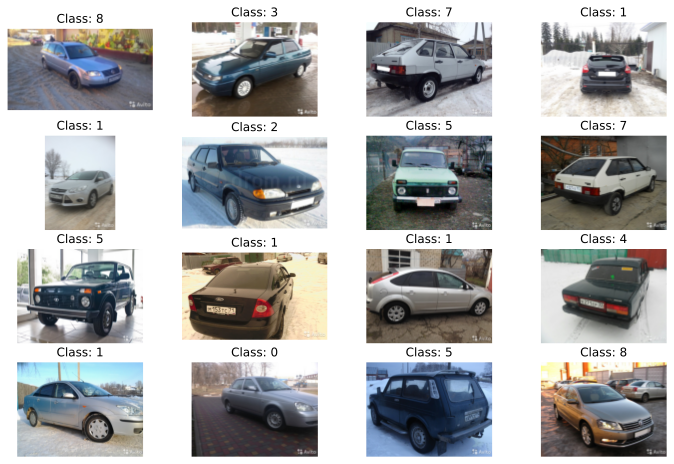

In [10]:
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=16)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(4,4, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()
# Checking images.

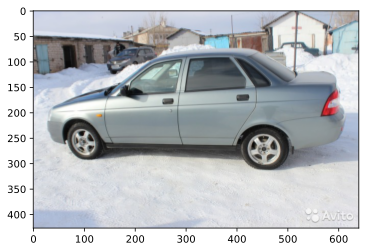

(640, 427)

In [11]:
image = PIL.Image.open(PATH+'/train/0/100155.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

# 3 Предобработка данных

In [12]:
AUGMENTATIONS = albumentations.Compose([
    albumentations.GaussianBlur(p=0.05),
    albumentations.RandomBrightness(limit=0.2, p=0.5),
    albumentations.ShiftScaleRotate(shift_limit=0.0625, 
                                    scale_limit=0.01,
                                    interpolation=1,
                                    border_mode=4,
                                    rotate_limit=20,
                                    p=.75),
    albumentations.OneOf([
        albumentations.CenterCrop(height=224, width=200),
        albumentations.CenterCrop(height=200, width=224)],
        p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, 
                                                contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, 
                                                contrast_limit=0.1)],
        p=0.5),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1,
                            always_apply=False,
                            p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

In [13]:
train_datagen = ImageDataAugmentor(
    rescale=1./255,
    augment=AUGMENTATIONS,
    validation_split=VAL_SPLIT
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [14]:

train_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,
    subset='training'
)

valid_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='validation'
)

/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:332: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.


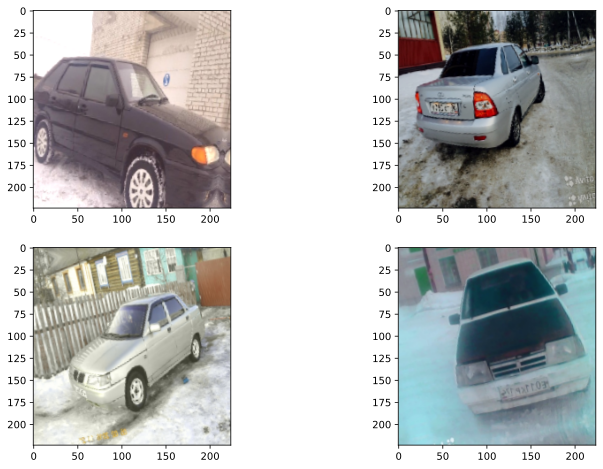

In [15]:
# Checking images.
x,y = train_generator.next()

plt.figure(figsize=(12,8))

for i in range(0,4):
    image = x[i]
    plt.subplot(2,2, i+1)
    plt.imshow(image)
plt.show()

# 4. Deep learning 

##### 4.1 Основная идея решения: взять предобученую на ImageNet сеть EfficientNetB7 и дообучить под задачу. Затем на основе рекомендаций улучшить качество модели,

In [16]:
base_model = efn.EfficientNetB7(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE
)

258441216/258434480 [==============================] - 3s 0us/step


In [17]:
base_model.summary()

Model: "efficientnet-b7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 64) 1728        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 64) 256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 64) 0           stem_bn[0][0]                    
____________________________________________________________________________________

In [18]:
base_model.trainable = False

In [19]:
model = Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D(),)
model.add(layers.Dense(256, 
                      activation='relu', 
                      bias_regularizer=l2(1e-4),
                      activity_regularizer=l2(1e-5)),)
model.add(layers.BatchNormalization(),)
model.add(layers.Dropout(0.25),)
model.add(layers.Dense(CLASS_NUM, activation='softmax'))

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 7, 7, 2560)        64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               655616    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 64,756,890
Trainable params: 658,698
Non-trainable params: 64,098,192
______________________________________

In [21]:
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.functional.Functional object at 0x7f0b08485590> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f0a5133e210> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f0a51342e90> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f0a5134a590> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f0aed752210> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f0a512e0e90> True


##### 4.2 Обучение модели

In [22]:
model.compile(loss="categorical_crossentropy", 
              optimizer=optimizers.Adam(lr=LR), 
              metrics=["accuracy"])

In [23]:
# Добавим ModelCheckpoint. 
# Эта функция позволяет сохранять прогресс обучения модели, 
# чтобы в нужный момент можно было его подгрузить и дообучить модель.
checkpoint = ModelCheckpoint('best_model.hdf5', 
                             monitor = ['val_accuracy'], 
                             verbose = 1,
                             mode = 'max')
earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 4,
                          restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.25,
                              patience=2,
                              min_lr=0.0000001,
                              verbose=1,
                              mode='auto')
callbacks_list = [checkpoint, earlystop, reduce_lr]

In [24]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        validation_data=valid_generator, 
        validation_steps=valid_generator.samples//valid_generator.batch_size,
        epochs=5,
        callbacks=callbacks_list
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/5
389/389 [==============================] - 215s 501ms/step - loss: 2.0911 - accuracy: 0.3281 - val_loss: 1.1525 - val_accuracy: 0.5909

Epoch 00001: saving model to best_model.hdf5
Epoch 2/5
389/389 [==============================] - 187s 480ms/step - loss: 1.5196 - accuracy: 0.4682 - val_loss: 1.0742 - val_accuracy: 0.6086

Epoch 00002: saving model to best_model.hdf5
Epoch 3/5
389/389 [==============================] - 186s 477ms/step - loss: 1.4114 - accuracy: 0.5112 - val_loss: 1.0926 - val_accuracy: 0.6002

Epoch 00003: saving model to best_model.hdf5
Epoch 4/5
389/389 [==============================] - 184s 473ms/step - loss: 1.3437 - accuracy: 0.5334 - val_loss: 1.0049 - val_accuracy: 0.6530

Epoch 00004: saving model to best_model.hdf5
Epoch 5/5
389/389 [==============================] - 184s 472ms/step - loss: 1.3024 - accuracy: 0.5441 - val_loss: 0.9426 - val_accuracy: 0.6656

Epoch 00005: saving model to best_model.hdf5


In [25]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        validation_data=valid_generator, 
        validation_steps=valid_generator.samples//valid_generator.batch_size,
        epochs=10,
        callbacks=callbacks_list
)

Epoch 1/10
389/389 [==============================] - 183s 471ms/step - loss: 1.2696 - accuracy: 0.5475 - val_loss: 0.9147 - val_accuracy: 0.6846

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
389/389 [==============================] - 182s 468ms/step - loss: 1.2424 - accuracy: 0.5622 - val_loss: 0.9274 - val_accuracy: 0.6730

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
389/389 [==============================] - 181s 465ms/step - loss: 1.2208 - accuracy: 0.5665 - val_loss: 0.9107 - val_accuracy: 0.6836

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
389/389 [==============================] - 181s 466ms/step - loss: 1.2187 - accuracy: 0.5660 - val_loss: 0.8994 - val_accuracy: 0.6843

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
389/389 [==============================] - 181s 466ms/step - loss: 1.1771 - accuracy: 0.5828 - val_loss: 0.8711 - val_accuracy: 0.6852

Epoch 00005: saving model to best_model.hdf5
Epoch 6/10
389/389 [====================

In [26]:
model.save('../working/model_step1.hdf5')
model.load_weights('best_model.hdf5')

In [27]:
# Checking the accuracy.
scores = model.evaluate_generator(valid_generator, steps=len(valid_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


98/98 [==============================] - 37s 376ms/step - loss: 0.8182 - accuracy: 0.7170
Accuracy: 71.70%


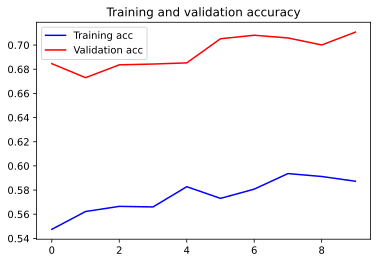

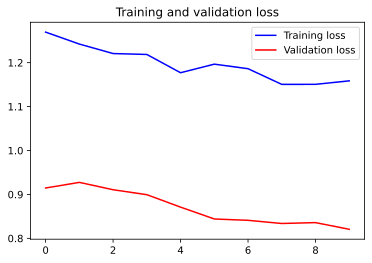

In [28]:
# Checking the plots.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss'] 
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()


##### 4.3 Настройка нейронной сети

In [29]:
# Unfreeze all layers.
base_model.trainable = True

# Fine-tune from this layer onwards.
fine_tune_at = len(base_model.layers)//2

# Freeze all the layers before the `fine_tune_at` layer.
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False


In [30]:
# Compiling the model.
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(lr=LR),
    metrics=["accuracy"]
)

In [31]:
# Neural network training.
history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        validation_data=valid_generator, 
        validation_steps=valid_generator.samples//valid_generator.batch_size,
        epochs=EPOCHS,
        callbacks=callbacks_list
)

Epoch 1/10
389/389 [==============================] - 254s 588ms/step - loss: 1.3495 - accuracy: 0.5786 - val_loss: 0.6216 - val_accuracy: 0.8170

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
389/389 [==============================] - 220s 565ms/step - loss: 0.5356 - accuracy: 0.8279 - val_loss: 0.2631 - val_accuracy: 0.9166

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
389/389 [==============================] - 220s 566ms/step - loss: 0.3583 - accuracy: 0.8886 - val_loss: 0.3587 - val_accuracy: 0.8792

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
389/389 [==============================] - 225s 577ms/step - loss: 0.3148 - accuracy: 0.9021 - val_loss: 0.4030 - val_accuracy: 0.8711

Epoch 00004: saving model to best_model.hdf5

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 5/10
389/389 [==============================] - 220s 565ms/step - loss: 0.2142 - accuracy: 0.9313 - val_loss: 0.1717 - val_accuracy: 0.9423

Epoc

In [32]:
# Saving model + Loading best weights.
model.save('../working/model_step2.hdf5')
model.load_weights('best_model.hdf5')

In [33]:
# Checking the accuracy.
scores = model.evaluate_generator(valid_generator, steps=len(valid_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

98/98 [==============================] - 38s 386ms/step - loss: 0.1531 - accuracy: 0.9498
Accuracy: 94.98%


##### 4.4 Обучение всей сети

In [34]:
BATCH_SIZE = 8

In [35]:
base_model.trainable = True

In [36]:
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,
    subset='training'
)

valid_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='validation'
)

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.


In [37]:
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(lr=LR),
    metrics=["accuracy"]
)

In [38]:
history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        validation_data=valid_generator, 
        validation_steps=valid_generator.samples//valid_generator.batch_size,
        epochs=10,
        callbacks=callbacks_list
)

Epoch 1/10
1556/1556 [==============================] - 634s 389ms/step - loss: 0.9943 - accuracy: 0.6919 - val_loss: 0.6859 - val_accuracy: 0.7780

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
1556/1556 [==============================] - 600s 386ms/step - loss: 0.8038 - accuracy: 0.7373 - val_loss: 0.4381 - val_accuracy: 0.8640

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
1556/1556 [==============================] - 600s 386ms/step - loss: 0.5919 - accuracy: 0.8096 - val_loss: 0.7175 - val_accuracy: 0.8012

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
1556/1556 [==============================] - 600s 386ms/step - loss: 0.6389 - accuracy: 0.7946 - val_loss: 0.9472 - val_accuracy: 0.8586

Epoch 00004: saving model to best_model.hdf5

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 5/10
1556/1556 [==============================] - 601s 386ms/step - loss: 0.3886 - accuracy: 0.8794 - val_loss: 0.2127 - val_accuracy: 0.

In [39]:
model.save('../working/model_step3.hdf5')
model.load_weights('best_model.hdf5')

In [40]:
scores = model.evaluate_generator(valid_generator, steps=len(valid_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

389/389 [==============================] - 40s 103ms/step - loss: 0.1684 - accuracy: 0.9501
Accuracy: 95.01%


# 5. Prediction

In [41]:
test_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False,
    seed=RANDOM_SEED
)

Found 6675 validated image filenames.


In [42]:
len(test_generator)

835

In [43]:
test_generator.reset()

predictions = model.predict_generator(
    test_generator, 
    steps=len(test_generator), 
    verbose=1
) 

predictions = np.argmax(
    predictions, 
    axis=-1)

label_map = (train_generator.class_indices)

label_map = dict((v,k) for k,v in label_map.items())

predictions = [label_map[k] for k in predictions]

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


835/835 [==============================] - 68s 77ms/step


In [44]:
filenames_with_dir = test_generator.filenames

submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, 
                          columns=['Id', 'Category'])

submission['Id'] = submission['Id'].replace('test_upload/','')

submission.to_csv('submission.csv', index=False)

# 6. Резюме и выводы


Резюме о проделанной работе:
   - инициализированы необходимые библиотеки, заданы условия визуализации и загрузили набор данных;
   - настроили гиперпараметры: количество эпох, размер пакета, скорость обучения, коэффициент проверочной выборки и размер изображения;
   - увеличили наши изображения несколькими способами, увеличив таким образом размер выборки;
   - загрузили предварительно обученную модель EfficientNet B7, изменили «голову», добавили слой пакетной нормализации и оптимизатор скорости обучения Адама;
   - настроили функции обратного вызова для сохранения промежуточного прогресса, остановки, если нет прогресса по метрике качества, и замедления скорости обучения, если нет прогресса по метрике потерь;
   - обучили модель трижды - с замороженными весами, предварительно обученными в ImageNet, с половиной весов и со всеми весами;
   - предсказали данные стандартным способом.
   
По результатам можно сделать следующие выводы:

   - Увеличение количества эпох улучшает результат, если не доводить его до переобучения.
   - Уменьшение размера партии увеличивает время эксперимента, но помогает избежать ошибок ОЗУ.
   - Низкая скорость обучения замедляет эксперимент, но помогает избежать локальных минимумов.
   - Большой размер изображения замедляет эксперимент и перегружает оперативную память, но дает больше возможностей.
   - Увеличение изображения - хороший инструмент для увеличения размера выборки.
   - Пошаговое обучение улучшает результаты, но не было значительной разницы между полуобученной и полностью обученной сетью.
   - Очень важно следить за размером пакета, иначе обучение сети может быть прервано ошибкой ОЗУ.
   - Увеличение времени тестирования действительно улучшает результат прогнозирования.
   